In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pickle
import json
import pandas as pd
from datetime import datetime
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
from nilearn.reporting import make_glm_report
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
sys.path.append('..')
from utils.data import Subject, load_participant_list, create_dummy_regressors

In [3]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

sub_ids = load_participant_list(base_dir)

In [4]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '02', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [5]:
model_params = {
    'model_name': 'rsa',
    'tr': 2.33384,
    'hrf_model': 'spm',
    'noise_model': 'ar1',
    'smoothing_fwhm': 5,
    'high_pass': 0.01,
    'motion_type': 'basic',
    'fd_thresh': 0.5,
    'std_dvars_thresh': 2.5,
    'scrub': 'dummies',
    'include_physio': True,
    'brain_mask': True,
}

run = 'test'

In [6]:
# Parameters
model_name = model_params["model_name"]
tr = model_params["tr"]
hrf_model = model_params["hrf_model"]
noise_model = model_params["noise_model"]
smoothing_fwhm = model_params["smoothing_fwhm"]
high_pass = model_params["high_pass"]
include_physio = model_params["include_physio"]
brain_mask = model_params["brain_mask"]
motion_type = model_params["motion_type"]
fd_thresh = model_params["fd_thresh"]
std_dvars_thresh = model_params["std_dvars_thresh"]
scrub = model_params["scrub"]

In [7]:
# Load confounds
confounds, sample_mask = subject.load_confounds(run, motion_type=motion_type,
                                                fd_thresh=fd_thresh, std_dvars_thresh=std_dvars_thresh,
                                                scrub=(0 if scrub == 'dummies' else scrub))
if include_physio:
    physio_regressors = subject.load_physio_regressors(run)
    confounds = confounds.join(physio_regressors)

In [8]:
if scrub == 'dummies':
    dummies = create_dummy_regressors(sample_mask, len(confounds))
    confounds = pd.concat([confounds, dummies], axis=1)

In [9]:
# Load fMRI volume
img_path = subject.img.get(run)
fmri_img = load_img(img_path)

In [10]:
if brain_mask:
    brain_mask_path = subject.brain_mask.get(run)
    brain_mask = load_img(brain_mask_path)
else:
    brain_mask = None

n = fmri_img.shape[-1]
frametimes = np.linspace(tr / 2., (n - .5) * tr, n)

In [ ]:
events = getattr(subject, run).extend_events_df(columns_event={'first_stim':'first_stim_presentation'})

In [13]:
events['trial_type'] = events.apply(
    lambda row: f"{row['trial_type']}_{int(row['first_stim'])}" if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
    axis=1
)

In [14]:
events.head(15)

,onset,duration,trial_type,trial,first_stim
0,0.009226,0.817357,first_stim_presentation_8,1,8.0
1,0.826583,0.364869,second_stim_presentation,1,0.0
2,1.191453,0.000000,response,1,0.0
3,1.210246,2.151995,purple_frame,1,0.0
4,3.362241,7.240122,iti,1,0.0
5,10.602363,0.934128,first_stim_presentation_6,2,6.0
6,11.536491,0.329929,second_stim_presentation,2,0.0
7,11.866420,0.000000,response,2,0.0
8,11.870114,2.185362,purple_frame,2,0.0
9,14.055476,6.222508,iti,2,0.0


In [15]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

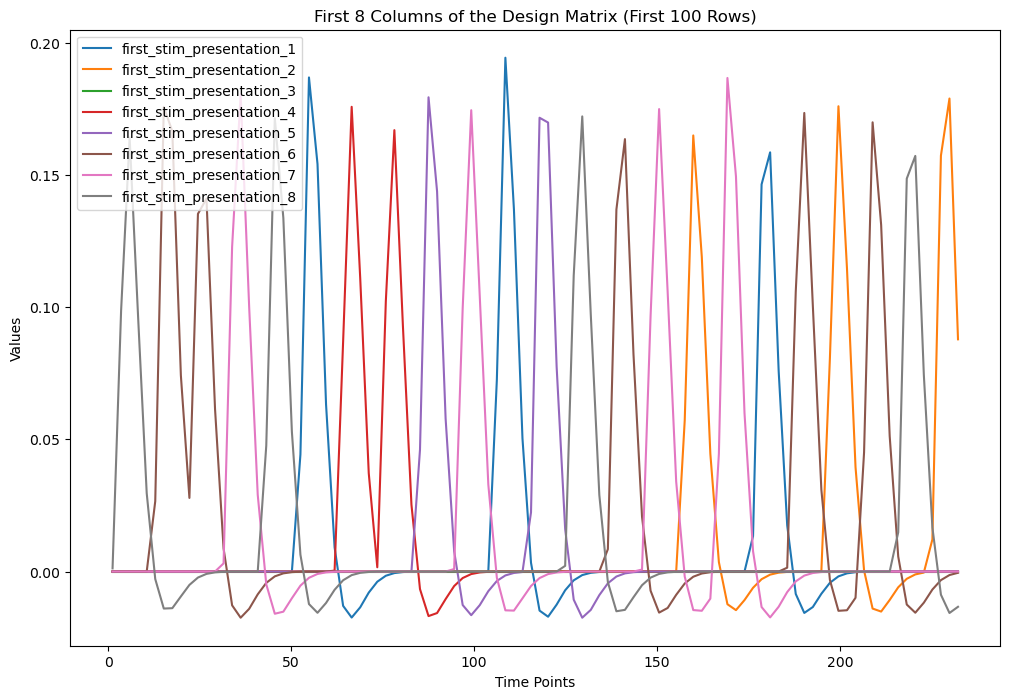

In [20]:
# Select the first 8 columns and the first 100 rows
subset_design_matrix = design_matrix.iloc[:100, :8]

# Plot the subset of the design matrix
subset_design_matrix.plot(figsize=(12, 8))
plt.legend(loc='best')
plt.title('First 8 Columns of the Design Matrix (First 100 Rows)')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.show()

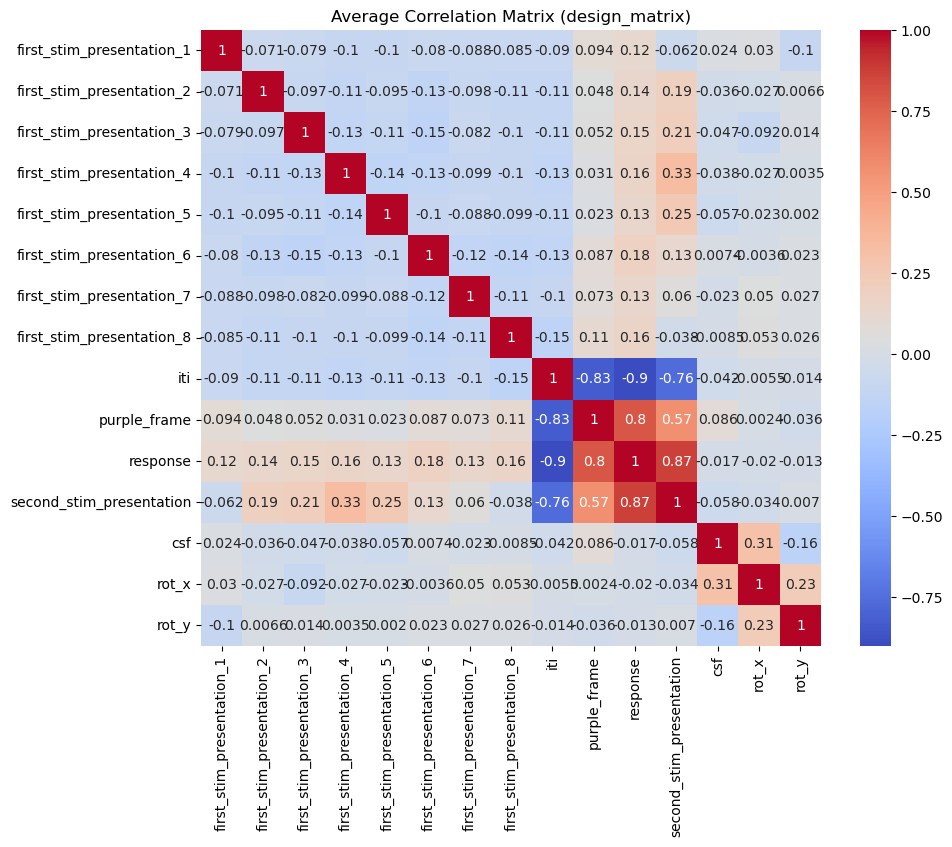

In [24]:
# Compute the average correlation matrices
average_correlation_matrix = design_matrix.iloc[:, :15].corr().values

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot the correlation matrix for design_matrix
sns.heatmap(average_correlation_matrix, xticklabels=design_matrix.columns[:15], 
            yticklabels=design_matrix.columns[:15], cmap='coolwarm', annot=True, ax=axes)
axes.set_title('Average Correlation Matrix (design_matrix)')

plt.show()